🛍️ RFM Analysis for Customer Segmentation
Objective:
Identify and categorize customers based on Recency, Frequency, and Monetary metrics to improve marketing strategies and retention.

Dataset:

Retail transactions dataset

Columns include: InvoiceDate, Customer ID, Revenue, etc.

Cleaned & preprocessed before analysis

Approach:

Data cleaning and preparation

Calculate Recency, Frequency, and Monetary values

Assign RFM scores using quintiles (1–5)

Combine scores to create RFM segments

Visualize customer distribution by segment

Provide actionable insights

In [1]:
import os

# Set PySpark environment variables to use Anaconda Python (customize these paths as needed)

os.environ['PYSPARK_PYTHON'] = '/opt/anaconda3/bin/python'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/opt/anaconda3/bin/python'


from pyspark.sql import SparkSession



# Start a new Spark session for this retail project
spark=SparkSession.builder.appName('Retail_Project1').getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/11 19:35:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import pandas as pd

# Read the raw retail data from an Excel file (source format)
df_excel=pd.read_excel("online_retail_II.xlsx")

# Convert the Excel sheet to CSV so Spark can easily consume it
df_excel.to_csv("retail_project_data.csv", index=False)

In [3]:
# Load CSV data into Spark DataFrame
df=spark.read.csv("retail_project_data.csv",header=True)

# Show first 5 rows and infer schema
df.show(5)
df.printSchema()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
only showing top 5 rows

root
 |-- Invoice: string (nullable = true)
 |--

In [4]:
# The default schema treats many fields as strings: we need to specify actual data types

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

schema = StructType([
    StructField("Invoice", StringType(), True),
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", TimestampType(), True),
    StructField("Price", DoubleType(), True),
    StructField("Customer ID", StringType(), True),
    StructField("Country", StringType(), True)
])

df=spark.read.csv("retail_project_data.csv",header=True,schema=schema)      
df.show(5)
df.printSchema()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
only showing top 5 rows

root
 |-- Invoice: string (nullable = true)
 |--

In [5]:
# Summarize dataset: count, mean, stddev, min, max for each numeric column
df.describe().collect()

# Check number of nulls in each column
from pyspark.sql.functions import col, sum as _sum
df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|       2928|       0|          0|    0|     107927|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+



In [6]:
# Remove problematic rows according to business rules:
# 1. Remove transactions with missing Customer ID.
# 2. Remove cancellation invoices (Invoice starting with 'C').
# 3. Remove rows with negative/zero Quantity or Price.

df=df.filter(col('Customer ID').isNotNull())
df=df.filter(~col('Invoice').startswith('C'))          # Tilde (~): NOT operator in PySpark
df=df.filter(df.Quantity>0).filter(df.Price>0) 

In [7]:
'''
This way:

Null Customer ID → dropped

Cancellation invoices → dropped

Negative/zero quantities → dropped

Negative/zero prices → dropped
'''

'\nThis way:\n\nNull Customer ID → dropped\n\nCancellation invoices → dropped\n\nNegative/zero quantities → dropped\n\nNegative/zero prices → dropped\n'

In [8]:
#we can filter in both ways:
'''

df.filter(col...)
or
df.filter(df.col_name....)

'''

'\n\ndf.filter(col...)\nor\ndf.filter(df.col_name....)\n\n'

In [9]:
df.count()

407664

In [10]:
#10k nearly rows are dropped

In [11]:
# Calculate Revenue for each row (i.e., revenue = quantity * price)

df=df.withColumn('Revenue',df.Price * df.Quantity)

In [12]:
# Aggregate: total revenue per Country and InvoiceDate

df.groupBy('Country','InvoiceDate').sum('Revenue').withColumnRenamed('sum_Rev','total_Rev').show()  

+--------------+-------------------+------------------+
|       Country|        InvoiceDate|      sum(Revenue)|
+--------------+-------------------+------------------+
|United Kingdom|2009-12-03 12:38:00|            189.15|
|United Kingdom|2009-12-03 13:22:00|             277.5|
|United Kingdom|2009-12-03 16:24:00|338.50000000000006|
|       Germany|2009-12-07 10:42:00|             367.9|
|United Kingdom|2009-12-07 12:32:00|238.84999999999997|
|United Kingdom|2009-12-07 15:10:00|            241.05|
|United Kingdom|2009-12-14 12:13:00|             38.66|
|United Kingdom|2009-12-15 14:30:00|            208.68|
|United Kingdom|2010-01-11 11:31:00|             595.0|
|United Kingdom|2009-12-08 12:30:00|309.70000000000005|
|United Kingdom|2009-12-11 10:08:00|327.31999999999994|
|United Kingdom|2009-12-14 14:34:00|132.51000000000002|
|United Kingdom|2009-12-18 09:16:00|            428.44|
|United Kingdom|2009-12-20 12:28:00|            229.37|
|United Kingdom|2010-01-04 14:00:00|189.67999999

In [13]:
from pyspark.sql.functions import to_date, month, year

# Extract year and month for time-based analysis
df=df.withColumn('InvoiceDate',to_date(col('InvoiceDate'), 'yyyy-MM-dd'))
df=df.withColumn('month',month(col('InvoiceDate')))
df=df.withColumn('year',year(col('InvoiceDate')))


# Aggregate revenue over year, month, and country
df.groupBy('year','month','Country').sum('Revenue').withColumnRenamed('sum_Rev','total_Rev').orderBy('year','month','Country').show() 

+----+-----+---------------+------------------+
|year|month|        Country|      sum(Revenue)|
+----+-----+---------------+------------------+
|2009|   12|      Australia|             271.1|
|2009|   12|        Austria|           1998.34|
|2009|   12|        Belgium|447.59999999999997|
|2009|   12|Channel Islands| 989.1800000000001|
|2009|   12|         Cyprus|3556.9799999999996|
|2009|   12|        Denmark|1437.6599999999999|
|2009|   12|           EIRE|          18170.46|
|2009|   12|        Finland|            549.08|
|2009|   12|         France| 6521.689999999999|
|2009|   12|        Germany|10096.850000000004|
|2009|   12|         Greece| 610.9499999999999|
|2009|   12|          Italy|            422.35|
|2009|   12|    Netherlands|15204.730000000001|
|2009|   12|         Norway|485.31000000000006|
|2009|   12|         Poland|371.82000000000005|
|2009|   12|       Portugal|2821.5799999999995|
|2009|   12|          Spain| 7950.179999999995|
|2009|   12|         Sweden|285.29999999

In [14]:
# Save cleaned DataFrame and aggregated DataFrames as Parquet for efficient storage/reloading
df.write.mode('overwrite').parquet('cleaned_DataFrame')

agg_df_RbyCC=df.groupBy('Country','InvoiceDate').sum('Revenue').withColumnRenamed('sum_Rev','total_Rev')

agg_df_RbyMC=df.groupBy('year','month','Country').sum('Revenue').withColumnRenamed('sum_Rev','total_Rev').orderBy('year','month','Country')

agg_df_RbyCC.write.mode('overwrite').parquet('RbyCC')
agg_df_RbyMC.write.mode('overwrite').parquet('RbyMC')

In [15]:
# Find top 10 customers by total revenue

df_cleaned=spark.read.parquet('cleaned_DataFrame')
top_N_cust=df_cleaned.groupBy('Customer ID').sum('Revenue').orderBy(col('sum(Revenue)').desc()).limit(10).show() 

+-----------+------------------+
|Customer ID|      sum(Revenue)|
+-----------+------------------+
|    18102.0|         349164.35|
|    14646.0| 248396.5000000001|
|    14156.0|196566.74000000002|
|    14911.0|152147.57000000018|
|    13694.0|131443.18999999994|
|    17511.0| 84541.17000000001|
|    15061.0|          83284.38|
|    16684.0| 80489.21000000002|
|    16754.0| 65500.06999999999|
|    17949.0| 60117.59999999999|
+-----------+------------------+



In [16]:
#monthly_trend=df_cleaned.groupBy("year", "month").sum("Revenue").orderBy(col("year").desc(), col("month").desc()).show()



In [17]:
df_cleaned.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



In [18]:
# RFM: Key metrics for customer segmentation

from pyspark.sql.functions import max, current_date, datediff,lit,countDistinct

# Find the most recent InvoiceDate in the dataset to define "today"
max_date = df_cleaned.select(max("InvoiceDate")).collect()[0][0]

# Recency: Days since last purchase for each customer
recency_df = df_cleaned.groupBy("Customer ID").agg(datediff(lit(max_date), max("InvoiceDate")).alias("Recency")).orderBy(col('Recency').desc())

# Frequency: Count of unique invoices per customer
frequency_df = df_cleaned.groupBy("Customer ID").agg(countDistinct("Invoice").alias("Frequency")).orderBy(col('Frequency'))

# Monetary: Total revenue per customer
monetary_df=df_cleaned.groupBy('Customer ID').sum('Revenue').withColumnRenamed('sum(Revenue)','Monetary').orderBy(col('Monetary').desc())

In [19]:
# Join R, F, M metrics into a single DataFrame
RFM_df=recency_df.join(frequency_df, 'Customer ID').join(monetary_df,'Customer ID')
RFM_df.show(5)

+-----------+-------+---------+------------------+
|Customer ID|Recency|Frequency|          Monetary|
+-----------+-------+---------+------------------+
|    13178.0|     32|       10|           8333.72|
|    15039.0|      3|       47|20116.989999999998|
|    12777.0|     92|        1| 519.4499999999999|
|    16939.0|    123|        3|             449.0|
|    16553.0|     31|       21|          10924.19|
+-----------+-------+---------+------------------+
only showing top 5 rows



In [20]:
from pyspark.sql.functions import ntile,concat_ws
from pyspark.sql.window import Window

# Score: assign 1-5 bucket to each metric (1: best, 5: worst for recency; 5: best for frequency/monetary)


recency_score=RFM_df.withColumn('recency_score', ntile(5).over(Window.orderBy(col("Recency").asc())))
frequency_score=RFM_df.withColumn('frequency_score', ntile(5).over(Window.orderBy(col("Frequency").desc())))
monetary_score=RFM_df.withColumn('monetary_score', ntile(5).over(Window.orderBy(col("Monetary").desc())))

# Combine all scores for each customer
RFM_score=recency_score.join(frequency_score, on='Customer ID').join(monetary_score, on='Customer ID')


# Concatenated and total RFM score
RFM_score_combibed=RFM_score.withColumn('RFM_score_combined',(concat_ws("",col('recency_score'),col('frequency_score'),col('monetary_score'))))
RFM_score_total=RFM_score.withColumn('RFM_score_total',col('recency_score')+col('frequency_score')+col('monetary_score'))

In [21]:
#segement analysis::
from pyspark.sql.functions import when

# Assign each customer to a segment based on their total RFM score
RFM_segmented = RFM_score_total.withColumn(
    "Segment",
    when(col("RFM_score_total") >= 13, "Champions") \
    .when((col("RFM_score_total") >= 10) & (col("RFM_score_total") <= 12), "Loyal Customers") \
    .when((col("RFM_score_total") >= 7) & (col("RFM_score_total") <= 9), "Potential Loyalist") \
    .when((col("RFM_score_total") >= 4) & (col("RFM_score_total") <= 6), "Needs Attention") \
    .otherwise("At Risk")
)
RFM_segmented.show(20)

+-----------+-------+---------+------------------+-------------+-------+---------+------------------+---------------+-------+---------+------------------+--------------+---------------+------------------+
|Customer ID|Recency|Frequency|          Monetary|recency_score|Recency|Frequency|          Monetary|frequency_score|Recency|Frequency|          Monetary|monetary_score|RFM_score_total|           Segment|
+-----------+-------+---------+------------------+-------------+-------+---------+------------------+---------------+-------+---------+------------------+--------------+---------------+------------------+
|    17377.0|      0|       60|14218.490000000003|            1|      0|       60|14218.490000000003|              1|      0|       60|14218.490000000003|             1|              3|           At Risk|
|    15856.0|      0|       26|17832.769999999997|            1|      0|       26|17832.769999999997|              1|      0|       26|17832.769999999997|             1|           

In [22]:
RFM_segmented.groupBy("Segment").count().orderBy(col("count").desc()).show()


+------------------+-----+
|           Segment|count|
+------------------+-----+
|   Loyal Customers| 1118|
|Potential Loyalist| 1058|
|         Champions|  914|
|   Needs Attention|  881|
|           At Risk|  341|
+------------------+-----+



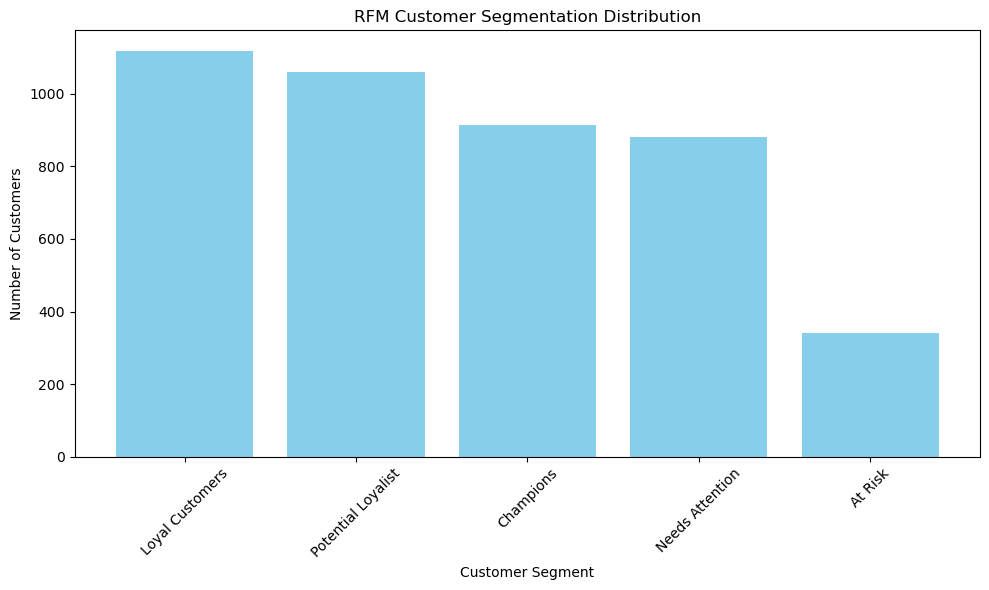

In [23]:
import matplotlib.pyplot as plt


# Convert Spark DataFrame to Pandas for plotting
segment_counts = RFM_segmented.groupBy("Segment").count().toPandas()
# Sort by count descending
segment_counts = segment_counts.sort_values(by="count", ascending=False)


plt.figure(figsize=(10,6))
plt.bar(segment_counts["Segment"], segment_counts["count"], color="skyblue")
plt.xticks(rotation=45)
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.title("RFM Customer Segmentation Distribution")
plt.tight_layout()
plt.show()


📌 Conclusion
In this project, we performed an RFM (Recency, Frequency, Monetary) analysis on transactional data using PySpark. The workflow involved:

ETL & Data Cleaning: Removed null values, filtered out negative quantities/prices, and calculated Revenue.

RFM Calculation: Computed Recency, Frequency, and Monetary metrics for each customer.

Scoring: Assigned RFM scores using ntile() for segmentation ranking.

Segmentation: Categorized customers into meaningful groups such as Champions, Loyal Customers, At Risk, etc.

Visualization: Created bar charts to show distribution of customer segments.

Key Insights
Champions and Loyal Customers represent the largest segments, indicating a strong base of repeat buyers.

At Risk customers should be targeted with retention campaigns before they churn.

Potential Loyalists could be converted into long-term buyers with personalized offers.

The distribution of segments shows opportunities for both retention and growth marketing.

Business Implications
Retention Strategies: Special offers, loyalty programs, and personalized communication for At Risk and Needs Attention segments.

Upselling/Cross-selling: Focus on Champions and Loyal Customers with premium products or bundles.

Nurturing New Buyers: Engage Potential Loyalists to increase purchase frequency.

Limitations & Next Steps
The dataset size is relatively small; results may differ with larger, more diverse data.

Segmentation was based only on RFM; additional behavioral and demographic data could improve targeting.

Future work could integrate time series trend analysis, predictive modeling (e.g., churn prediction), or recommendation systems.